In [1]:
Packages <- c("dplyr", "geosphere","fields","lattice", "ggplot2", "bbmle", "ncdf4","dplyr","tidyr", "stringr", "tidyverse", "raster", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")


In [2]:
#read in data and add site names
conn_mat_all <- brick("~/oceanography/ROMS/data/Camotes_Sea_Connectivity_Matrices_08_day_PLD_integer.nc", values=T) 
#read in the data for the number of grid cells per site (site ids are North- South, as in, Palanas is number 1)
sites_n <- read.table("~/oceanography/ROMS/input//camotes_vertices_sites_results_water_only.txt", sep=" ", header=T, stringsAsFactors = F)
#the order of sites in the connectivity matrix
sites_order <- read.table("~/oceanography/ROMS/input/sites_order_as_in_roms.txt", sep=" ", header=T, stringsAsFactors = F)

sites <- as.character(c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop", "Hicgop South", "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Pangasugan", "Visca", "Gabas", "Tamakin Dacot", "Haina", "Sitio Baybayon", "SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "CAI", "Other"))
site_ind <- c(seq(1,28, 1))
site_id <- as.data.frame(cbind(sites, site_ind), stringsAsFactors = F)
site_id$site_ind <- as.numeric(site_id$site_ind)


[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named sink BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"
[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named source BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"
[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named time BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"


In [3]:
#add in dates (seasons here are field seasons, not monsoon seasons)
col <- "date"
col2 <- "index"

season1 <- as.data.frame(seq(as.Date("2010/10/01"), as.Date("2011/05/31"), by="days"))
names(season1) <- col

season2 <- as.data.frame(seq(as.Date("2011/10/01"), as.Date("2012/05/31"), by="days"))
names(season2) <- col

season3 <- as.data.frame(seq(as.Date("2012/10/01"), as.Date("2013/05/31"), by="days"))
names(season3) <- col

season4 <- as.data.frame(seq(as.Date("2013/10/01"), as.Date("2014/04/18"), by="days"))
names(season4) <- col

all_dates <- bind_rows(season1, season2, season3, season4)
time_step <- as.data.frame(seq(1,930,1))
names(time_step)<- col2
all_dates2 <- bind_cols(time_step, all_dates)
dim(all_dates2)


[1] 930   2

In [4]:
head(season3)

date
2012-10-01
2012-10-02
2012-10-03
2012-10-04
2012-10-05
2012-10-06


In [5]:
#make each daily connectivity matrix into a df and then pull them all together into a list
#conn_mat_list <- vector("list", nrow(all_dates2))

#date_df <- do.call("rbind", replicate(784, date, simplify = FALSE))

conn_mat_full <- as.data.frame(matrix(nrow=0, ncol=4))

cols_conn_mat <- c("date","sink", "source", "number")
cols_tmp <- c("sink", "source", "number")

names(conn_mat_full) <- cols_conn_mat

for(i in 1:nrow(all_dates2)){
    
    index_eval <- all_dates2$index[i]
    
    tmp <- as.data.frame(conn_mat_all[[i]], xy=T)   #pull out a data frame for each date
    names(tmp) <- cols_tmp
    
    date <- filter(all_dates2, index==index_eval)[2] #grab the date
    date_df <- do.call("rbind", replicate(784, date, simplify = FALSE)) #make a df of the date
    tmp2 <- bind_cols(date_df, tmp)

 
    conn_mat_full <- rbind(conn_mat_full, tmp2) 
}



In [6]:
#connect site names
conn_mat_full2 <- left_join(conn_mat_full, site_id, by=c(source="site_ind")) %>%
    dplyr::select(-source) %>%
    rename(source="sites")
    
conn_mat_full3 <- left_join(conn_mat_full2, site_id, by=c(sink="site_ind")) %>%
    dplyr::select(-sink) %>%
    rename(destination="sites")

    

In [132]:
#make all versions of Hicgop "Hicgop South" to match empirical data
conn_mat_full3 <- conn_mat_full3 %>%
    mutate(source=ifelse(source=="Hicgop", "Hicgop South", source)) %>%
    mutate(destination=ifelse(destination=="Hicgop", "Hicgop South", destination))

#mark which sources/destinations were sampled in real life
UnsampledSites <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "Pangasugan", "Other", "CAI" )
#mark the monsoon seasons in which they dispersed, based on the same criteria I used for the parentage indirectly through the growth estimates
NEM <- c(11, 12, 1, 2, 3, 4, 5, 6)
SWM <- c(7, 8, 9, 10)

#add a column showing which sources and destinations were empirically sampled, and corresponding date/year/season data
conn_mat_full4 <- conn_mat_full3 %>%
    mutate(SourceSampled= ifelse(source %!in% UnsampledSites, "yes", "no")) %>%
    mutate(DestSampled= ifelse(destination %!in% UnsampledSites, "yes", "no")) %>%
    mutate(SimMonth=month(ymd(date))) %>%
    mutate(SimDay=month(ymd(date))) %>%
    mutate(SimYear=year(ymd(date))) %>%
    mutate(YearSampled=ifelse(date %in% season1$date, "2011", ifelse(date %in% season2$date, "2012", ifelse(date %in% season3$date, "2013", "2014")))) %>%
    mutate(YearSampled=as.factor(YearSampled)) %>%
    mutate(SimMonsoon=ifelse(SimMonth %in% NEM, "NEM", "SWM")) %>%
    rename(DailyParticles="number") %>%
    relocate(DailyParticles,.after=SimMonsoon)
    
#note to self, I think I messed up sources/destinations in the orginal for loop!!!! so I'm grouping by source below, but that's because the true destination column is misnamed "source" in the code and I haven't figured it out yet
#!!!!

##for unassigned, you want to keep these sites 2/8/2021 maybe delete this chunk
#ConnMatTotalRec <- conn_mat_full3 %>%     
#    filter(date %in% season3$date) %>%
#    group_by(destination) %>%
#    #dplyr::select(-date) %>%
#    mutate(TotalParticlesRec= sum(number)) %>%
#    distinct(destination, date, .keep_all = T) %>%
#    dplyr::select(destination, date, TotalParticlesRec) %>%
#    mutate(SimMonth=month(ymd(date))) %>%
#    mutate(SimYear=year(ymd(date))) %>%
#    mutate(YearSampled=ifelse(date %in% season1$date, "2011", ifelse(date %in% season2$date, "2012", ifelse(date %in% season3$date, "2013", "2014")))) %>%
#    mutate(YearSampled=as.factor(YearSampled))
#
#nrow(ConnMatTotalRec) 

In [133]:
head(conn_mat_full4)
#write.csv(conn_mat_full4, file="~/oceanography/script_output/SimConnectivityTable.csv", row.names=F)

date,source,destination,SourceSampled,DestSampled,SimMonth,SimDay,SimYear,YearSampled,SimMonsoon,DailyParticles
2010-10-01,Other,Palanas,no,yes,10,10,2010,2011,SWM,9
2010-10-01,Other,Wangag,no,yes,10,10,2010,2011,SWM,4
2010-10-01,Other,Magbangon,no,yes,10,10,2010,2011,SWM,11
2010-10-01,Other,Cabatoan,no,yes,10,10,2010,2011,SWM,12
2010-10-01,Other,Caridad Cemetery,no,yes,10,10,2010,2011,SWM,0
2010-10-01,Other,Caridad Proper,no,yes,10,10,2010,2011,SWM,1


In [134]:
#add together all of the particles for each season. At some point need to consider matching times that we sampled, from the fish meta-data
#replace XN with years
SimDispInt <- conn_mat_full4 %>%
    group_by(destination, YearSampled) %>%
    mutate(AnnTotalRec=sum(DailyParticles)) %>%
    mutate(AnnTotalRecFromSampSites=ifelse(DestSampled=="yes" & SourceSampled=="yes",sum(DailyParticles), 0))

#
#SimDispXNInt2 <- left_join(SitesNS, SimDispXNInt, by=c(site="source")) %>%
#    rename(source="site")
#SimDispXN <- left_join(SitesNS, SimDispXNInt2, by=c(site="destination")) %>%
#    rename(destination="site") #%>% #drop this for fitting the kernel, use for the model
#    #mutate(year="XN")

#SimDispXNRecSampInt <- ConnMatTotalRec %>%#the total recruits in the simulation for each destination site we empirically sampled
#    filter(destination %in% SimDispXN$destination) #%>%
#    #mutate(source="unsampled") #not really, just unsampled empirically. Use this to get the unassigned row?

#SimDispXNRecSamp <- SimDispXNInt %>% #left_join(SimDispXNInt, SimDispXNRecSampInt, by="destination") %>%
#    group_by(destination, date) %>%
#    mutate(TotalParticlesAssignedDaily=sum(ParticlesDaily)) %>% #Create a column for the total particles recruiting to a given destination for a given date, from a source we empirically sampled. ParticlesDaily should be less than or equal to TotalParticlesAssignedDaily
#    group_by(destination) %>%
#    mutate(TotalParticlesRec=sum(ParticlesDaily)) #%>% #Create a column for the total particles recruiting to a given destination across the simulations
#    #mutate(TotalUnassignedDaily=TotalParticlesRec-TotalParticlesAssignedDaily) #%>%
#    #dplyr::select(source, -Particles) 


In [139]:
tail(SimDispInt %>% filter(DestSampled=="yes" & SourceSampled=="no"))


date,source,destination,SourceSampled,DestSampled,SimMonth,SimDay,SimYear,YearSampled,SimMonsoon,DailyParticles,AnnTotalRec,AnnTotalRecFromSampSites
2014-04-18,Pangasugan,Poroc Rose,no,yes,4,4,2014,2014,NEM,0,5520,0
2014-04-18,Pangasugan,Visca,no,yes,4,4,2014,2014,NEM,0,16186,0
2014-04-18,Pangasugan,Gabas,no,yes,4,4,2014,2014,NEM,1,18547,0
2014-04-18,Pangasugan,Tamakin Dacot,no,yes,4,4,2014,2014,NEM,0,96006,0
2014-04-18,Pangasugan,Haina,no,yes,4,4,2014,2014,NEM,0,41826,0
2014-04-18,Pangasugan,Sitio Baybayon,no,yes,4,4,2014,2014,NEM,0,23995,0


In [42]:
#check that everything looks correct
test <- SimDispXN %>% filter(SumParticles >1)
18*18 #this should be the rows
#pdf("~/oceanography/script_output/HistNumParticlesRecruiting.pdf")
hist(test$SumParticles, breaks=50, xlab="Number of particles recruiting daily", main=NULL)
#dev.off()
#write.csv(SimDispXNRecSamp, file="~/oceanography/script_output/SimConnectivitySummaryTable.csv", row.names=F)

[1] 324

png 
  2

In [46]:
head(SimDispXNRecSamp)

destination,source,date,month,year,SumParticles,SumParticlesRec,TotalParticlesAssigned,TotalUnassigned
Palanas,Palanas,2010-10-01,10,2011,0,11299,0,11299
Palanas,Palanas,2010-10-02,10,2011,0,11299,0,11299
Palanas,Palanas,2010-10-03,10,2011,0,11299,0,11299
Palanas,Palanas,2010-10-04,10,2011,0,11299,0,11299
Palanas,Palanas,2010-10-05,10,2011,0,11299,0,11299
Palanas,Palanas,2010-10-06,10,2011,0,11299,0,11299


In [9]:
#put in North-South order for kernel fitting
SitesNS <- read.csv("~/parentage/text_file/sites_NS.txt", stringsAsFactors = F) %>%
    mutate(site=ifelse(site =="S. Magbangon" , "Magbangon", site)) %>%
    filter(site != "N. Magbangon") %>%
    dplyr::select( -index)

#SitesNS$index <- seq(1,18, 1) #might not need this....
#SitesNS$destination <- SitesNS$source


In [18]:
#try predicting the occurence of dispersal numbers with some kind of regression model
#put in North-South order for kernel fitting
SitesNS <- read.csv("~/parentage/text_file/sites_NS.txt", stringsAsFactors = F) %>%
    mutate(site=ifelse(site =="S. Magbangon" , "Magbangon", site)) %>%
    filter(site != "N. Magbangon") %>%
    dplyr::select( -index)

#SitesNS$index <- seq(1,18, 1) #might not need this....
#SitesNS$destination <- SitesNS$source

#join together all of the data first

#get a data frame with number of genetic observations and number of simulated for each site to site pair, as well as a pairwise distance matrix
centroids <- read.csv("~/parentage/kernel_fitting/1340_loci/input/site_centroids.csv", header=TRUE, stringsAsFactors = F) %>%
    mutate(site=ifelse(site =="S.Magbangon" , "Magbangon", site)) %>%
    filter(site != "N.Magbangon") %>%
    filter(site %in% SitesNS$site)


##calculate the distance from all potential parents and all potential offspring
all_possible_dists <- as.data.frame(rdist.earth(as.matrix(centroids[,c('lon', 'lat')]), as.matrix(centroids[,c('lon', 'lat')]), miles=FALSE, R=6371))
#
##attach the sample_ids to each distance, so you can also get site and year
colnames(all_possible_dists) <- centroids$site
all_possible_dists$site_i <- centroids$site
#
##gather into tidy 
all_possible_dists_tidy <- all_possible_dists %>%
    dplyr::select(site_i, everything()) %>%
    gather(2:19, key=site_j, value=dist_km) 
nrow(all_possible_dists_tidy)




[1] 324

In [20]:
head(all_possible_dists)

Cabatoan,Caridad Cemetery,Caridad Proper,Elementary School,Gabas,Haina,Hicgop South,Magbangon,Palanas,Poroc Rose,Poroc San Flower,San Agustin,Sitio Baybayon,Sitio Lonas,Sitio Tugas,Tamakin Dacot,Visca,Wangag,site_i
0.000000,3.038692e+00,3.789504e+00,7.740421,15.924821,24.577900,6.114777,0.2495696,2.660843,12.798627,11.983814,11.424317,24.9105625,10.887220,6.9777870,23.388433,13.968751,2.134203,Cabatoan
3.038692,9.493530e-05,7.636321e-01,4.775854,13.080011,22.050107,3.098730,3.2880591,5.692889,9.910745,9.057865,8.489400,22.4353814,7.932351,3.9858954,20.820482,11.117050,5.159038,Caridad Cemetery
3.789504,7.636321e-01,9.493530e-05,4.014960,12.331398,21.355234,2.335660,4.0382676,6.447918,9.157139,8.299290,7.729948,21.7509720,7.170873,3.2226326,20.118346,10.368474,5.915797,Caridad Proper
7.740421,4.775854e+00,4.014960e+00,0.000000,8.353842,17.625239,1.730523,7.9844248,10.395512,5.163004,4.287362,3.716243,18.0747093,3.156729,0.8191489,16.354591,6.395648,9.874129,Elementary School
15.924821,1.308001e+01,1.233140e+01,8.353842,0.000000,9.763888,10.084115,16.1581187,18.527005,3.197051,4.121372,4.693835,10.3497100,5.293913,9.1715042,8.438427,1.962985,18.030177,Gabas
24.577900,2.205011e+01,2.135523e+01,17.625239,9.763888,0.000000,19.312642,24.7849757,26.992011,12.750061,13.706185,14.246287,0.8007074,14.845685,18.4303146,1.329357,11.500480,26.553263,Haina


In [67]:
disp_dist <- read.csv(file="~/parentage/colony2/20200605_1340loci/results/20200624colony_dispersaldirection.csv", header=T, stringsAsFactors=F) %>%
    #filter(year=="2014") %>%#testing effect of time
    filter(year %in% c("2012", "2013", "2014")) %>% #, "2014"
    dplyr::select(year, dist_par_km, offs_site, par_site) %>%
    group_by(offs_site, par_site) %>%
    summarise(obs_disp=n())

sum(disp_dist$obs_disp)#should be 37 for years of overlap between model and genetics, 21 for 2013
#read in empirical kernel data
load("~/parentage/r_data/cumulative_prop_hab_sampled_by_site.RData")
kernels <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/kernel_fitting_summary.csv", header=T)
RecruitsSampled <- read.csv(file="~/oceanography/empirical_data/genetics/NumSampledRecruits.csv", header=T)
PropSamp <- cumulative_prop_hab_sampled_by_site %>%
    mutate(total_possible_sample_anems = ifelse(site=="Caridad Proper", 4, total_possible_sample_anems) ) %>%
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(site=="Caridad Proper" & total_anems_sampled==4, 1, total_prop_hab_sampled_anems_tidied) ) %>%
    mutate(total_possible_sample_anems = ifelse(site=="Sitio Lonas", total_anems_sampled, total_possible_sample_anems) ) %>%
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(site=="Sitio Lonas", 1, total_prop_hab_sampled_anems_tidied) )%>%
    mutate(total_prop_hab_sampled_anems_tidied= ifelse(is.nan(total_prop_hab_sampled_anems_tidied), 0, total_prop_hab_sampled_anems_tidied) ) %>%
    dplyr::select(site, time_frame, end_year, total_prop_hab_sampled_anems_tidied) %>%
    filter(time_frame==end_year)

PropSamp$site <- gsub(". ", ".", PropSamp$site, fixed=TRUE)



`summarise()` regrouping output by 'offs_site' (override with `.groups` argument)


[1] 37

In [72]:
head(PropSamp)


site,time_frame,end_year,total_prop_hab_sampled_anems_tidied
Cabatoan,2012,2012,0.4230769
Caridad Cemetery,2012,2012,0.0000000
Caridad Proper,2012,2012,0.0000000
Elementary School,2012,2012,0.0000000
Gabas,2012,2012,0.0000000
Haina,2012,2012,0.0000000


In [69]:
SimPlusGenWithDistInt <- left_join(SimDispXN, all_possible_dists_tidy, by=c(destination="site_j", source="site_i")) %>%
    rename(ExpDisp="SumParticles")

SimPlusGenWithDist <- left_join(SimPlusGenWithDistInt, disp_dist, by=c(destination="offs_site", source="par_site")) %>%
    mutate(obs_disp=ifelse(is.na(obs_disp), 0, obs_disp))


In [84]:
SimGenMetaInt <- left_join(SimPlusGenWithDist, PropSamp, by=c(destination="site", year="end_year")) %>%
    dplyr::select(-time_frame) %>%
    mutate(prop_samp=ifelse(is.na(total_prop_hab_sampled_anems_tidied), 0, total_prop_hab_sampled_anems_tidied))
#SimGenMeta <- left_join(SimGenMetaInt, , by=c(destination="site"))

#(SimGenMetaInt)


In [51]:
mean(SimPlusGenWithDist$obs_disp)
var(SimPlusGenWithDist$obs_disp)
#overdispersion?
#no, because residual deviance of the model is not greater than the df
#Residual deviance: 774.21  on 1287  degrees of freedom

[1] 0.08950617

[1] 0.2607083

In [87]:
test_mod_int <- glm(obs_disp ~ ExpDisp* year + prop_samp + dist_km  , data=SimGenMetaInt, family="poisson")
summary(test_mod_int)



Call:
glm(formula = obs_disp ~ ExpDisp * year + prop_samp + dist_km, 
    family = "poisson", data = SimGenMetaInt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7876  -0.4492  -0.4089  -0.3718   5.1993  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -2.163e+00  2.222e-01  -9.734   <2e-16 ***
ExpDisp           1.709e-05  2.557e-05   0.668   0.5038    
year2012          1.118e-01  2.953e-01   0.379   0.7050    
year2013         -1.127e-01  2.733e-01  -0.412   0.6800    
year2014         -2.395e-02  2.678e-01  -0.089   0.9287    
prop_samp        -5.593e-01  4.898e-01  -1.142   0.2534    
dist_km          -2.908e-02  1.395e-02  -2.084   0.0371 *  
ExpDisp:year2012  4.773e-05  4.117e-05   1.159   0.2463    
ExpDisp:year2013  1.153e-04  4.583e-05   2.516   0.0119 *  
ExpDisp:year2014  2.997e-05  4.272e-05   0.702   0.4829    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for 

In [24]:
test_mod <- glm(obs_disp ~ ExpDisp +year+ dist_km, data=SimPlusGenWithDist, family="poisson")
summary(test_mod)

#following this tutorial
#https://stats.idre.ucla.edu/r/dae/poisson-regression/
#the median is not quite 0, but close. if the median deviance is 0, then the deviance residuals are approximately normal and the model is specified correctly



Call:
glm(formula = obs_disp ~ ExpDisp + year + dist_km, family = "poisson", 
    data = SimPlusGenWithDist)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5963  -0.4546  -0.4150  -0.3795   5.1143  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.181e+00  2.237e-01  -9.749  < 2e-16 ***
ExpDisp      3.666e-05  1.271e-05   2.885  0.00392 ** 
year2012     2.729e-02  2.642e-01   0.103  0.91774    
year2013     3.267e-02  2.646e-01   0.123  0.90174    
year2014     2.718e-02  2.641e-01   0.103  0.91804    
dist_km     -3.168e-02  1.393e-02  -2.275  0.02293 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 792.12  on 1295  degrees of freedom
Residual deviance: 780.03  on 1290  degrees of freedom
AIC: 920.74

Number of Fisher Scoring iterations: 15


In [25]:
AIC(test_mod, test_mod_int)

,df,AIC
test_mod,6,920.7388
test_mod_int,9,920.9138


In [26]:
#this isn't significant, which means the residual difference is small enough here to say the model fits reasonably well
with(test_mod, cbind(res.deviance = deviance, df = df.residual,
  p = pchisq(deviance, df.residual, lower.tail=FALSE)))


res.deviance,df,p
780.0319,1290,1


In [ ]:
#how much devience is explained here?

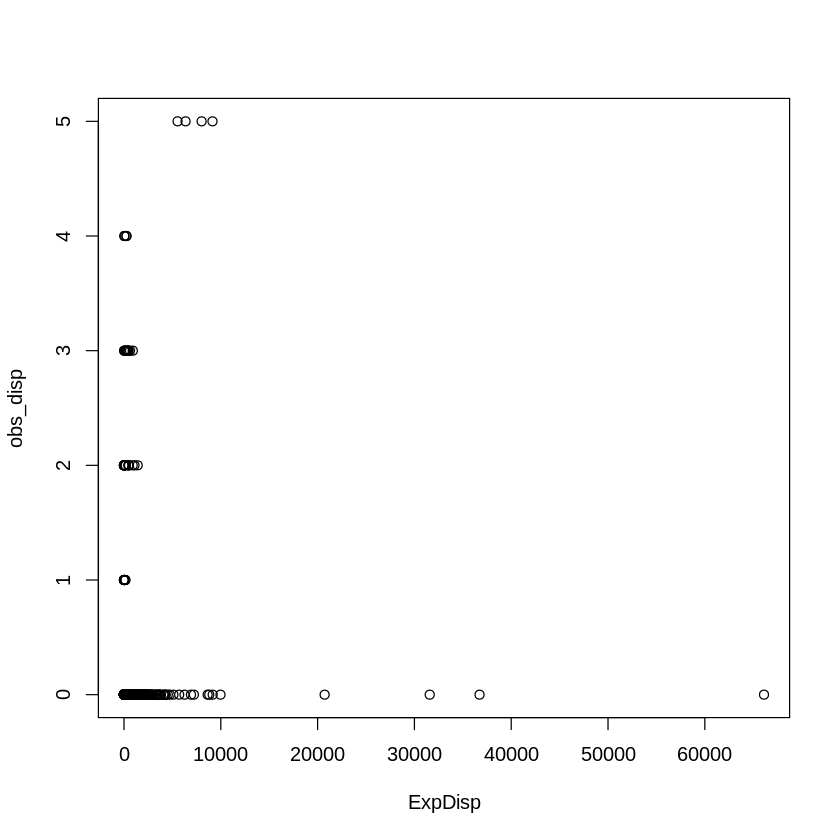

In [27]:
plot(obs_disp ~ ExpDisp, data=SimPlusGenWithDist)

In [29]:
#plot(test_mod_int)

In [32]:
#plot predicted model
range(SimPlusGenWithDist$ExpDisp)

[1]     0 66114

In [33]:
exp_disp_range <- seq(0, 66114, 1)

In [36]:
obs_disp_pred <- predict(test_mod_int,type="response")

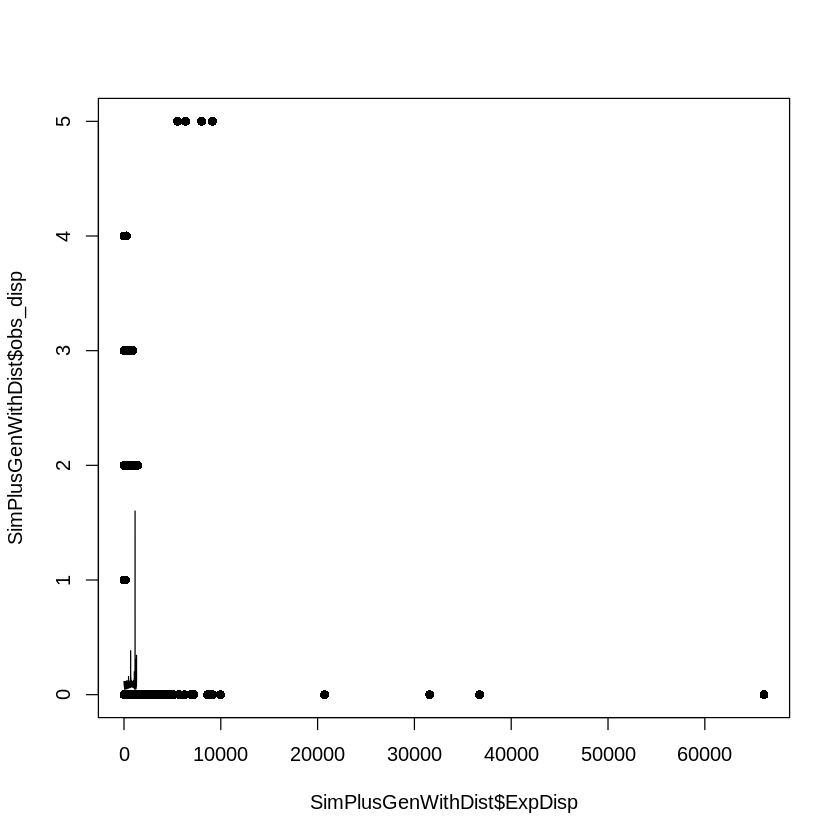

In [39]:
plot( SimPlusGenWithDist$ExpDisp, SimPlusGenWithDist$obs_disp, pch = 16)#, xlab = "WEIGHT (g)", ylab = "VS")

lines(obs_disp_pred)

In [85]:
#sources are rows, columns are destinations, checked this? check again
#also check if it matters that these are in alphabetical order YES it should be alphabetical
SimDisp2013Mat <- SimDisp2013 %>%
    group_by(destination, source) %>%
    spread(destination, SumParticles)
#
rownames(SimDisp2013Mat) <- SimDisp2013Mat$source
SimDisp2013Mat$source <- NULL

Warning message:
“Setting row names on a tibble is deprecated.”

In [86]:
#add in unassigned 
RowtoAddInt <- SimDisp2013RecSamp %>%
    ungroup() %>%
    arrange(destination) %>%
    dplyr::select(TotalUnassigned)

RowtoAdd <- as.data.frame(t(RowtoAddInt))
colnames(RowtoAdd) <- colnames(SimDisp2013Mat)

FullSimDisp2013 <- rbind(SimDisp2013Mat, RowtoAdd)
rownames(FullSimDisp2013) <- NULL

In [71]:
FullSimDisp2012

NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
454,699,877,8,0,0,651,429,66,13,22,87,416,87,59,0,0,126
310,1761,1132,44,0,0,84,354,57,10,32,199,357,166,54,0,0,69
404,563,784,11,0,0,77,291,35,19,92,325,442,307,71,0,0,53
185,360,769,524,0,5,1536,246,31,42,70,176,193,252,652,0,0,31
48,35,95,961,6253,38,654,73,8,172,448,2136,102,3555,912,25,2843,5
16,1,9,127,20,1366,40,9,1,27,36,78,10,19,49,827,41,0
554,862,1587,531,4,19,1208,337,90,174,353,484,615,677,513,12,4,140
400,1034,1146,12,0,0,343,175,177,6,15,71,688,71,45,0,0,215
209,161,190,1,0,0,12,143,42,0,0,0,1406,0,13,0,0,239
63,180,418,419,1,36,179,7,6,273,506,811,75,2011,440,32,99,13


In [35]:
SimDisp2012Mat

Cabatoan,Caridad Cemetery,Caridad Proper,Elementary School,Gabas,Haina,Hicgop South,Magbangon,Palanas,Poroc Rose,Poroc San Flower,San Agustin,Sitio Baybayon,Sitio Lonas,Sitio Tugas,Tamakin Dacot,Visca,Wangag
454,699,877,8,0,0,651,429,66,13,22,87,416,87,59,0,0,126
310,1761,1132,44,0,0,84,354,57,10,32,199,357,166,54,0,0,69
404,563,784,11,0,0,77,291,35,19,92,325,442,307,71,0,0,53
185,360,769,524,0,5,1536,246,31,42,70,176,193,252,652,0,0,31
48,35,95,961,6253,38,654,73,8,172,448,2136,102,3555,912,25,2843,5
16,1,9,127,20,1366,40,9,1,27,36,78,10,19,49,827,41,0
554,862,1587,531,4,19,1208,337,90,174,353,484,615,677,513,12,4,140
400,1034,1146,12,0,0,343,175,177,6,15,71,688,71,45,0,0,215
209,161,190,1,0,0,12,143,42,0,0,0,1406,0,13,0,0,239
63,180,418,419,1,36,179,7,6,273,506,811,75,2011,440,32,99,13


In [87]:
#turn into parentage matrix

#SimDisp2012Mat <- SimDisp2012 %>%
#    ungroup() %>%
#    spread(source, destination, SumParticles)
    

#make the rest of the kernel input files
Assignments <- FullSimDisp2013
Adult_sample_proportions <- matrix(nrow=18, ncol=1, 1) #we sampled all sites completely because we are working with simulated data
Sampled_reefs <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/site_index_all.csv", header=FALSE))[,18] #sampled all reefs in the distance matrix/area/centroid files
Distances <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/distance_matrix_unsurveyed.csv", header=FALSE))[-2, -2]  #drop a magbangon row  
Reef_sizes <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.csv", header=FALSE))[]
Centroids <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/centroids_unsurveyed.csv", header=T))



In [88]:
a=-10
b=10


x <- list(Distances=Distances, Assignments=Assignments, Sampled_reefs=Sampled_reefs, Reef_sizes=Reef_sizes, Adult_sample_proportions=Adult_sample_proportions) #put inputs into a list because that's the bbmle format

Sim2013Fit <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 8), method="L-BFGS-B", data=x, control=list(maxit=500)))
Sim2013Fit

#doen't look right. Maybe fix theta, optimize k


Call:
mle2(minuslogl = LL_kt_bbmle, start = list(k = -3, theta = 1), 
    method = "L-BFGS-B", data = x, lower = c(-10, 0.15), upper = c(10, 
        8), control = list(maxit = 500))

Coefficients:
    k theta 
   10     8 

Log-likelihood: -47193.78 

In [ ]:
#monsoon season prep
NEM_months <- c(11, 12, 1, 2, 3, 4)
SWM_months <- c(5, 6, 7, 8, 9, 10)

NEM <- conn_mat_full4 %>%
    filter(month %in% NEM_months) %>%
    group_by(source, destination) %>%
    summarise(conn=max(fraction))

SWM <- conn_mat_full4 %>%
    filter(month %in% SWM_months) %>%
    group_by(source, destination) %>%
    summarise(conn=max(fraction))